### Objective:

A financial institution would like to grow the client population by improving their targeting strategy.   

Third party credit data is used for the same. The dataset contains 389 features with 39508 datapoints.

**Loading Dataset**

In [1]:
import pandas as pd

missing_values = ["n/a", "na", "--", ""]
data=pd.read_csv("Data.csv",na_values = missing_values)
data.head(2)

C:\Users\teena\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (328,336) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ActIntAmusementParkVisit,ActIntZooVisit,ActIntWineLovers,ActIntDoityourselfers,ActIntHomeImproveSpenders,ActIntHuntingEnthusiasts,BuyerLuxuryStoreShop,LifestyleMedicalPolicy,ActIntDigitalMagNewspaper,ActIntAttendsEducationProg,...,MortgageLoanType,ESTCURRMTHLYMORTGPAYMTRNG,MosaicGlobalZip4,PresenceOfCreditCard,InterestInCrafts,InterestInGourmetCooking,ComputersPeripherals,HiTechOwner,InternetOnlineSubscriber,Flag
0,26.0,68.0,65.0,37.0,53.0,41.0,40.0,69.0,78.0,67.0,...,NaN,0U,E,U,Y,Y,Y,Y,Y,0
1,47.0,46.0,2.0,31.0,9.0,68.0,5.0,14.0,48.0,10.0,...,C,1M,B,Y,U,U,Y,Y,Y,0


**Importing necessary libraries**

In [2]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import logging
logging.captureWarnings(True)
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score, confusion_matrix,plot_roc_curve,roc_curve
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from collections import Counter
import random
random.seed(10)

Using TensorFlow backend.


- Analysing columns which got warning for mixed data types

In [3]:
data.iloc[:,328].head(2)

0    1.0
1    1.0
Name: RuralUrbanCountySizeCode, dtype: object

In [4]:
data.iloc[:,328].head(2)

0    1.0
1    1.0
Name: RuralUrbanCountySizeCode, dtype: object

- Checking size of the dataset

In [5]:
data.shape

(39508, 389)

- Checking if there are any columns with all NA values

In [6]:
data.columns[data.isna().all()]

Index([], dtype='object')

- Making a copy of the dataset

In [7]:
df=data.copy()

### Data Preprocessing

**Dropping columns which have upto 20% of NA values**

In [8]:
data=data.dropna(thresh=len(data)*0.2, axis=1)

**Splitting the data into target variable and predictor variables**

In [9]:
target=data[["Flag"]]
data=data.drop(["Flag"], axis=1)
data.shape

(39508, 380)

- **Splitting the data into numerical and categorical data**
- **Imputing missing data**
    - Categorical data is imputed with mode
    - Numerical data is imputed with mean

In [10]:
categorical=data.select_dtypes(include=['object', 'category'])
numerical=data.select_dtypes(include=['number'])

for column in categorical.columns:
    categorical[column].fillna(categorical[column].mode()[0], inplace=True)
numerical=numerical.fillna(numerical.mean())

**Scaling and Encoding**
**Why Scaling**
- Numerical data is scaled using StandardScaler function
- StandardScaler
- Categorical data is label-encoded first and then onehot-encoded


In [11]:
scaler=StandardScaler()

numerical_names=numerical.columns
numerical=scaler.fit_transform(numerical)
numerical=pd.DataFrame(numerical, columns=numerical_names)

categorical=categorical.astype(str)

labelencoder = LabelEncoder()
categorical=categorical.apply(labelencoder.fit_transform)

onehotencoder = OneHotEncoder() 
categorical_values=onehotencoder.fit_transform(categorical)
categorical_names=onehotencoder.get_feature_names(input_features=categorical.columns)

categorical_values=pd.DataFrame(categorical_values.todense())
categorical_values.columns=categorical_names
categorical=categorical_values


- Merging the categorical data and numerical data to single data frame

In [12]:
clean_data=pd.concat([numerical,categorical], axis=1)
clean_data.head(2)
clean_data.shape

(39508, 908)

**Splitting the data into train and test data**

In [13]:
X_train, X_test, y_train,y_test = train_test_split(clean_data,target, test_size=0.3, random_state=42)

In [14]:
print(clean_data.shape)

(39508, 908)


In [15]:
print(target.shape)

(39508, 1)


In [16]:
print(y_test.value_counts())

Flag
0       10597
1        1256
dtype: int64


### Defining Model and Metrics to evaluate
- For the classification problem in hand a **Sequential** model is used.
    - Activation functions used are *Rectified Linear Unit(ReLU)* on first two layers and *Sigmoid* on the output layer 
    - The activation function is responsible for transforming the summed weighted input from the node into the activation of    the node or output for that input.
    - The model is compiled specifying *binary_crossentropy*  as loss function and *rmsprop* as the optimizer.
    - Loss function is used to evaluate a set of weights and the optimizer is used to search through different weights for the network and report any optional metrics to be collected during training.
    - Early stopping is used to stop the training once the model performanace stops improving.
    - Validation accuracy is monitored in the early stopping to stop training. 
    - Model is evalauated on test data.
- **Precision** and **Recall** are used to evaluate the performance of the model.
    - Precision is the ratio between the correct predictions and the total predictions of that class.
    - Recall is the ratio of the correct predictions and the total items in that class.
- **Confusion Matrix** is also shown to check raw number of classification of every test sample.
- **AUC-ROC** is used to visualize the performance of the classification problem.
    - Receiver Operating Characteristic curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system.
    - It is created by plotting the True Positive Rate against False Positive Rate.
    - Curve closer to top-left indicates a good classifier that separates both classes well. A curve that is at a 45-degree is considered to have no prediction capacity.  
    - AUC, Area Under Curve, represents the degree of separabaility. Higher the AUC, the better the model is predicting 0s as 0s and 1s as 1s.


In [17]:
def roc_curve_(y_true, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_true, preds)
    roc_auc = metrics.auc(fpr, tpr)
    fig=plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.title('Receiver Operating Characteristic')
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return plt
    

def seq_model(input_data, in_dim, train_y, test_x, test_y, n, m, p):
    model = Sequential()
    model.add(Dense(n,activation='relu',input_dim=in_dim))
    model.add(Dropout(0.2))
    model.add(Dense(m,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    #specificity=keras.metrics.SpecificityAtSensitivity(0.5,num_thresholds=3)
    #model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=["accuracy",specificity])
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=p,mode='max',restore_best_weights=True)
    model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=["accuracy"])
    hist=model.fit(input_data, train_y,epochs=100, batch_size=256, callbacks = [early_stopping], verbose=0,validation_split=0.20) #,
    score=model.evaluate(test_x,test_y,batch_size=256)
    accuracy=score[1]
    pred= model.predict(test_x)
    y_pred = np.where(pred < 0.5,0,1)
    #print("y_pred", y_pred.value_count())
    #print(test_y.value_count())
    Con_matrix= confusion_matrix(test_y, y_pred)
    #Con_matrix.columns=[1,0]
    precision=precision_score(test_y, y_pred, average="binary")
    recall=recall_score(test_y, y_pred, average="binary")
    #fig=metrics.plot_roc_curve(hist, X_test, y_test) 
    plot_=roc_curve_(y_test,y_pred)
    print("\n Accuracy of the model is:", accuracy, "\n")
    print("Precision of the model is:", precision, "\n")
    print("Recall of the model is:", recall, "\n")
    print("Confusion Matrix of the model is: ","\n", Con_matrix ,"\n")
    return 
    

**Base Model and its metrics**

Restoring model weights from the end of the best epoch
Epoch 00033: early stopping
11853/11853 [==============================] - 0s 23us/step

 Accuracy of the model is: 0.8938665390014648 

Precision of the model is: 0.4868421052631579 

Recall of the model is: 0.02945859872611465 

Confusion Matrix of the model is:  
 [[10558    39]
 [ 1219    37]] 



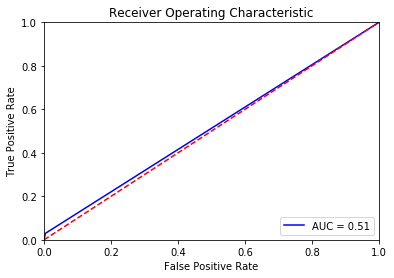

In [18]:
base_model=seq_model(X_train,X_train.shape[1],y_train, X_test,y_test,256, 256, 30)

**Result of the base model:**
- The base model does not have any classification capability.
- AUC is 0.51 and Recall is 0.02 which is extremely less.

### Feature Selection

- Feature selection is used to find and select features that contribute most to the target variable. 
- In all feature selection procedures, it is a good practice to select the features by examining only the training set. This is to avoid overfitting.
- Feature selection done is on the train set initially and then changes are transfered to the test set later.
- **selectFromModel**object from sklearn library is used to automatically select the features.
- In the first step, **Logistic Regression** model with ***Lasso regularization*** is used to select features. Features for which coefficients are non-zero are selected as they are important. 
- **Random Forest** is used in the second step to extract important features. Since each tree is built over random extraction of observations and features, trees are decorrelated and less prone to overfitting.
- Finally, **SelectKBest** is used. It uses ***f_classif*** function is used to score features and then removes all but "k" highest scoring features.

In [19]:
selected_LR = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='saga'))

selected_data_LR=selected_LR.fit_transform((X_train), y_train)
selected_feat_LR = X_train.columns[(selected_LR.get_support())]

selected_data_LR=pd.DataFrame(selected_data_LR)
selected_data_LR.columns=selected_feat_LR

print("The number of slected features after step one is:", selected_data_LR.shape[1])
selected_data_LR.head(2)

The number of slected features after step one is: 762


,ActIntAmusementParkVisit,ActIntZooVisit,ActIntWineLovers,ActIntDoityourselfers,ActIntHomeImproveSpenders,ActIntHuntingEnthusiasts,BuyerLuxuryStoreShop,LifestyleMedicalPolicy,ActIntDigitalMagNewspaper,ActIntAttendsEducationProg,...,InterestInCrafts_0,InterestInCrafts_1,InterestInGourmetCooking_0,InterestInGourmetCooking_1,ComputersPeripherals_0,ComputersPeripherals_1,HiTechOwner_0,HiTechOwner_1,InternetOnlineSubscriber_0,InternetOnlineSubscriber_1
0,0.401396,0.603799,1.669904,-0.921474,0.333477,-0.972411,0.516278,-0.029728,0.471398,-1.539914,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.061772,0.875516,0.285593,-0.824674,-1.450020,-1.386777,1.480922,-0.902537,1.113907,0.984746,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [20]:
selected_RF = SelectFromModel(RandomForestClassifier(n_estimators = 100))

selected_data_RF=selected_RF.fit(X_train[selected_feat_LR], y_train)
selected_feat_RF = X_train[selected_feat_LR].columns[(selected_RF.get_support())]

selected_data_RF=pd.DataFrame(selected_data_LR[selected_feat_RF])
selected_data_RF.columns=selected_feat_RF

print("The number of slected features after step two is:", selected_data_RF.shape[1])
selected_data_RF.head(2)


The number of slected features after step two is: 298


,ActIntAmusementParkVisit,ActIntZooVisit,ActIntWineLovers,ActIntDoityourselfers,ActIntHomeImproveSpenders,ActIntHuntingEnthusiasts,BuyerLuxuryStoreShop,LifestyleMedicalPolicy,ActIntDigitalMagNewspaper,ActIntAttendsEducationProg,...,ForeignvsDomestic,MorevsLessExpensive,LuxuryvsMidPriced,NewvsUsed,MidRangeCarvsTrucks,TimeZone,RuralUrbanCountySizeCode_0,RuralUrbanCountySizeCode_1,I1DeceasedIndicator_0,I1DeceasedIndicator_1
0,0.401396,0.603799,1.669904,-0.921474,0.333477,-0.972411,0.516278,-0.029728,0.471398,-1.539914,...,-0.536958,-0.496667,1.814455,0.247622,-0.766493,-0.416040,0.0,1.0,0.0,1.0
1,2.061772,0.875516,0.285593,-0.824674,-1.450020,-1.386777,1.480922,-0.902537,1.113907,0.984746,...,0.606949,-0.606679,-0.455591,-1.526309,-0.037204,-0.872958,0.0,1.0,0.0,1.0


In [21]:
selected_KB = SelectKBest(f_classif, k= 150)
selected_data_KB= selected_KB.fit(X_train[selected_feat_RF], y_train)

selected_feat_KB = X_train[selected_feat_RF].columns[(selected_KB.get_support())]

selected_data_KB=pd.DataFrame(selected_data_RF[selected_feat_KB])
selected_data_KB.columns=selected_feat_KB

print("The number of slected features after step three is:", selected_data_KB.shape[1])
selected_data_KB.head(2)

The number of slected features after step three is: 150


,ActIntZooVisit,ActIntWineLovers,BuyerLuxuryStoreShop,LifestyleMedicalPolicy,ActIntAttendsEducationProg,ActIntMLBEnthusiast,ActIntNFLEnthusiast,ActIntNHLEnthusiast,ActIntPlayGolf,BuyerLuxuryHomeGoodShopper,...,CountyECHVIndex,AmericanOrigin,EuropeanOrigin,AsianOrigin,ForeignvsDomestic,MorevsLessExpensive,LuxuryvsMidPriced,NewvsUsed,TimeZone,RuralUrbanCountySizeCode_1
0,0.603799,1.669904,0.516278,-0.029728,-1.539914,-0.151939,-1.013507,0.828230,0.237859,0.810490,...,0.368482,0.237546,0.749018,-0.614130,-0.536958,-0.496667,1.814455,0.247622,-0.416040,1.0
1,0.875516,0.285593,1.480922,-0.902537,0.984746,-1.843955,-0.223849,-0.894549,-0.485988,-0.641814,...,-0.900658,-0.266524,-0.247884,0.438107,0.606949,-0.606679,-0.455591,-1.526309,-0.872958,1.0


#### Checking the train data for number of samples in each class

In [22]:
print(y_train.value_counts())

Flag
0       24811
1        2844
dtype: int64


In [23]:
##### Resampling the data using RandomOverSampler method

In [24]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversample.fit_resample(selected_data_KB, y_train)

Counter(y_resampled)

Counter({1: 24811, 0: 24811})

### Resampled Models
**Examining the model with different number of Nodes and Patience argument**

Restoring model weights from the end of the best epoch
Epoch 00092: early stopping
11853/11853 [==============================] - 0s 9us/step

 Accuracy of the model is: 0.8205517530441284 

Precision of the model is: 0.2365396249243799 

Recall of the model is: 0.31130573248407645 

Confusion Matrix of the model is:  
 [[9335 1262]
 [ 865  391]] 



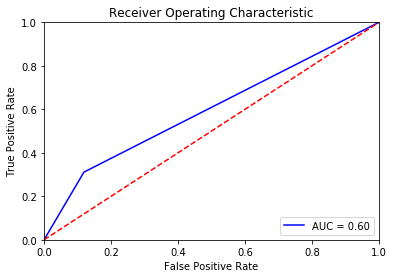

In [25]:
resampled_model=seq_model(X_resampled,X_resampled.shape[1],y_resampled, X_test[selected_feat_KB],y_test,256, 256, 30)

11853/11853 [==============================] - 0s 9us/step

 Accuracy of the model is: 0.8302539587020874 

Precision of the model is: 0.23786407766990292 

Recall of the model is: 0.2730891719745223 

Confusion Matrix of the model is:  
 [[9498 1099]
 [ 913  343]] 



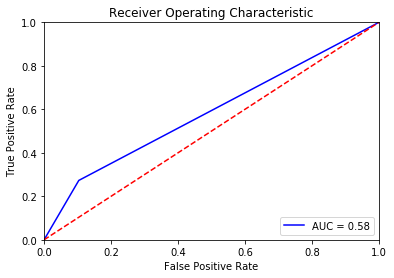

In [26]:
resampled_model=seq_model(X_resampled,X_resampled.shape[1],y_resampled, X_test[selected_feat_KB],y_test,256, 256, 20)

Restoring model weights from the end of the best epoch
Epoch 00043: early stopping
11853/11853 [==============================] - 0s 9us/step

 Accuracy of the model is: 0.8054500818252563 

Precision of the model is: 0.2248427672955975 

Recall of the model is: 0.34156050955414013 

Confusion Matrix of the model is:  
 [[9118 1479]
 [ 827  429]] 



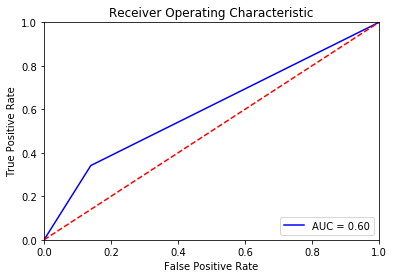

In [27]:
resampled_model=seq_model(X_resampled,X_resampled.shape[1],y_resampled, X_test[selected_feat_KB],y_test,256, 256, 10)

11853/11853 [==============================] - 0s 21us/step

 Accuracy of the model is: 0.8287353515625 

Precision of the model is: 0.2388663967611336 

Recall of the model is: 0.2818471337579618 

Confusion Matrix of the model is:  
 [[9469 1128]
 [ 902  354]] 



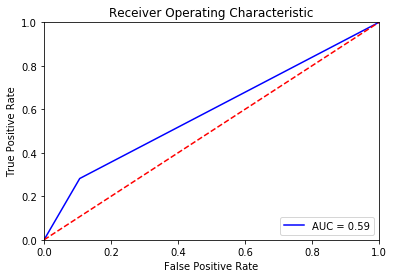

In [28]:
resampled_model=seq_model(X_resampled,X_resampled.shape[1],y_resampled, X_test[selected_feat_KB],y_test,512, 512,30)

Restoring model weights from the end of the best epoch
Epoch 00051: early stopping
11853/11853 [==============================] - 0s 25us/step

 Accuracy of the model is: 0.7910233736038208 

Precision of the model is: 0.2148528724894909 

Recall of the model is: 0.3662420382165605 

Confusion Matrix of the model is:  
 [[8916 1681]
 [ 796  460]] 



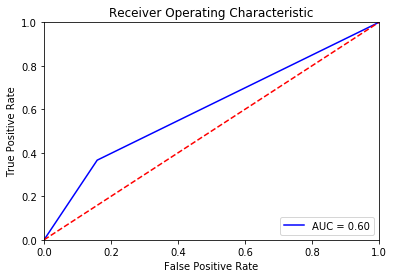

In [29]:
resampled_model=seq_model(X_resampled,X_resampled.shape[1],y_resampled, X_test[selected_feat_KB],y_test,512, 512,20)

Restoring model weights from the end of the best epoch
Epoch 00016: early stopping
11853/11853 [==============================] - 0s 19us/step

 Accuracy of the model is: 0.6725723743438721 

Precision of the model is: 0.1854780733285406 

Recall of the model is: 0.6162420382165605 

Confusion Matrix of the model is:  
 [[7198 3399]
 [ 482  774]] 



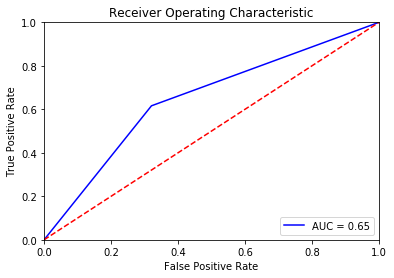

In [30]:
resampled_model=seq_model(X_resampled,X_resampled.shape[1],y_resampled, X_test[selected_feat_KB],y_test,512, 256,10)

Restoring model weights from the end of the best epoch
Epoch 00044: early stopping
11853/11853 [==============================] - 0s 16us/step

 Accuracy of the model is: 0.7979414463043213 

Precision of the model is: 0.2273815222594543 

Recall of the model is: 0.3781847133757962 

Confusion Matrix of the model is:  
 [[8983 1614]
 [ 781  475]] 



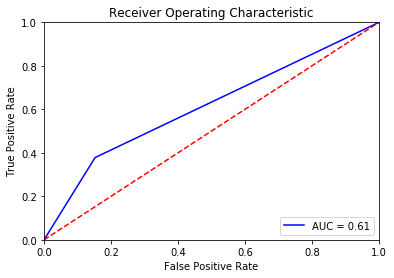

In [31]:
resampled_model=seq_model(X_resampled,X_resampled.shape[1],y_resampled, X_test[selected_feat_KB],y_test,512, 256,20)

11853/11853 [==============================] - 0s 18us/step

 Accuracy of the model is: 0.8161646723747253 

Precision of the model is: 0.22708456534594915 

Recall of the model is: 0.3057324840764331 

Confusion Matrix of the model is:  
 [[9290 1307]
 [ 872  384]] 



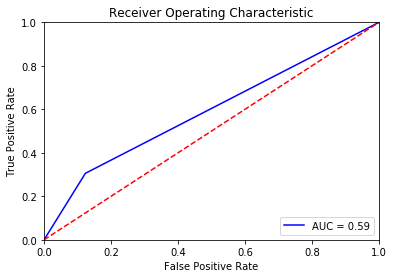

In [32]:
resampled_model=seq_model(X_resampled,X_resampled.shape[1],y_resampled, X_test[selected_feat_KB],y_test,512, 256,30)

### Results:

- Model is built with different hyperparameters.
- Recall is the desired measure of model performance in this case. 
- Less number of False Negatives is required as the instituition does not want desired candidate to be classified as undesired. 
- The highest recall obtained is 0.61 with an accuracy of 0.67. 
- Although, higher accuracy scores are recorded, they do not help with solving the problem at hand.
- Other model building techniques or algorithms can be tried to improve the performance of the model.

### References:

https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/                                                 
https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/                         
https://keras.io/guides/sequential_model/
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html                               
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html                                   
https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/                                                               
https://stackoverflow.com/questions/36950394/how-to-decide-the-size-of-layers-in-keras-dense-method